In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-data-set/diabetes.csv


<a id="table"></a>
<h1 style="background-color:lightgreen;font-family:newtimeroman;font-size:450%;text-align:center;border-radius: 15px 50px;">Prediction of diabetes using logistic regression</h1>

**Logistic regression** is a classification model in machine learning, extensively used in clinical analysis. It uses probabilistic estimations which help in understanding the relationship between the dependent variable and one or more independent variables. Diabetes, being one of the most common diseases around the world, when detected early, may prevent the progression of the disease and avoid other complications. In this work, we design a prediction model, that predicts whether a patient has diabetes, based on certain diagnostic measurements included in the dataset, and explore various techniques to boost performance and accuracy.

The first steps involve selecting the dataset for the model and evaluating its features. For this paper, the first dataset chosen is the PIMA Indian dataset. There are a total of nine features/variables, among which eight are predictor variables and 1 is the target variable. The features are as follows:

■Pregnancies: Number of times the patient was pregnant.

■Glucose: Plasma glucose concentration over two hours in an oral glucose tolerance test.

■BloodPressure: Diastolic blood pressure (mm Hg).

■SkinThickness: Triceps skin fold thickness (mm).

■Insulin: Two-Hour serum insulin (mu U/ml).

■BMI: Body mass index (weight in kg/(height in m)^2).

■DiabetesPedigreeFunction/DPF: A function that scores the likelihood of diabetes based on family history.

■Age: In years.

■Outcome: Class variable (0 if non-diabetic, 1 if diabetic). This is the target variable.

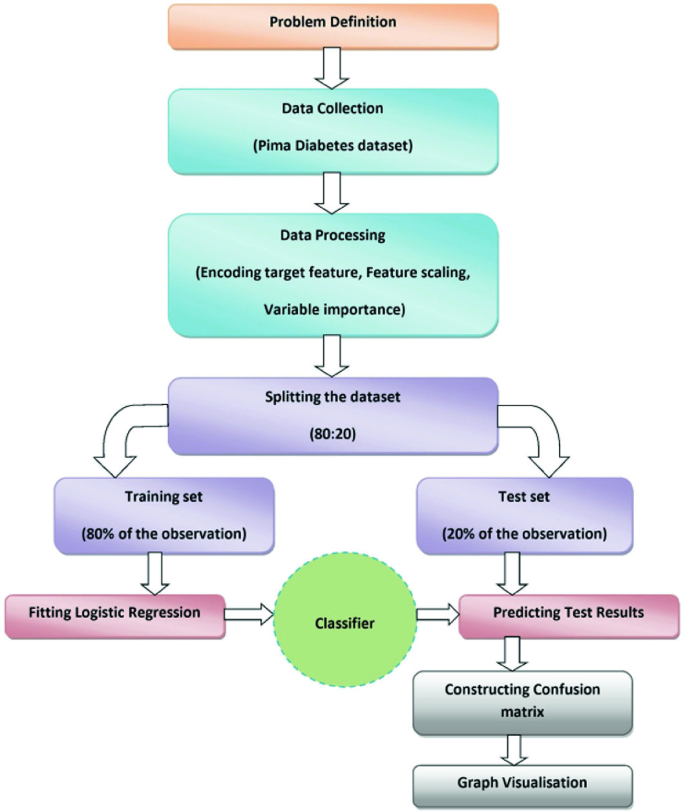

<a id="table"></a>
<h1 style="background-color:lightgreen;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table Of Content</h1>

* [1. Exploratory Data Analysis](#1)

* [2. Data Preprocessing](#2)

* [3. Model & Prediction](#3)

* [4. Model Evaluation](#4)

* [5. Model Validation: Holdout](#5)

* [6. Model Validation: 10-Fold Cross Validation](#6)

* [7. Prediction for a New Observation](#7)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import Warnings
import warnings
warnings.simplefilter(action="ignore")

# Setting Configurations:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

In [3]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

<a id="1"></a> <br>
# 1. Exploratory Data Analysis

In [4]:
df = pd.read_csv("/kaggle/input/diabetes-data-set/diabetes.csv")

In [5]:
df. head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [6]:
df.shape

(768, 9)

## Target's Analysis

The dependent variable "outcome" is a categorical variable. It consists of 1s and 0s. We look at the value_counts of their classes to analyze.

In [7]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

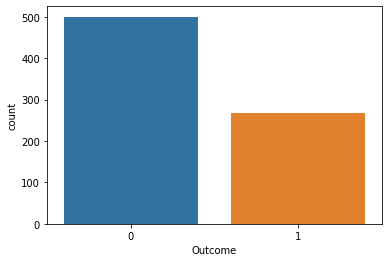

In [8]:
sns.countplot(x="Outcome", data=df)     # We can see the class information of the dependent variable in columns.
plt.show()

In [9]:
100 * df["Outcome"].value_counts() / len(df)

0   65.104
1   34.896
Name: Outcome, dtype: float64

## Analysis of Features

When we say visualize numeric variables, two things should come to mind:
1. boxplot: gives information about the distribution of the variable after ordering the values of the relevant numeric variable from smallest to largest.
2. histogram: It shows the values of the relevant numerical variable, how many observation frequencies there are in certain intervals.

In [10]:
df.describe().T     # Describe simply fetches numeric variables and summarizes their status.

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


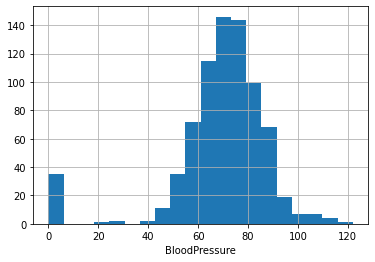

In [11]:
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.show()

**we can write a function to get the graph for all numeric variables.**

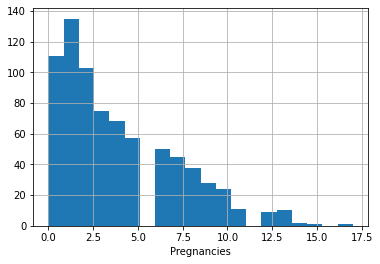

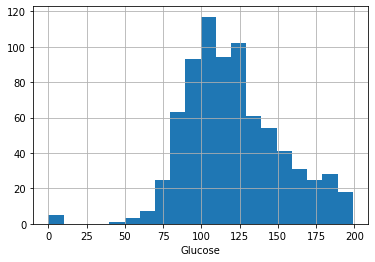

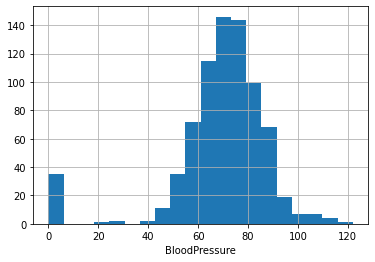

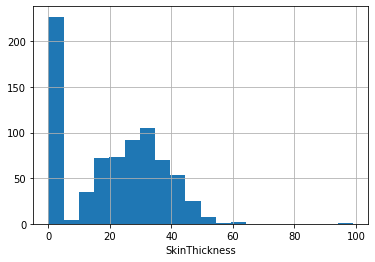

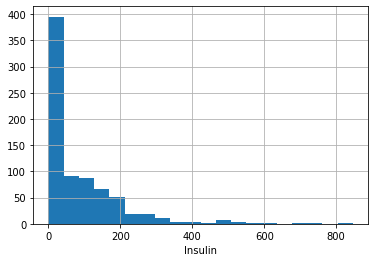

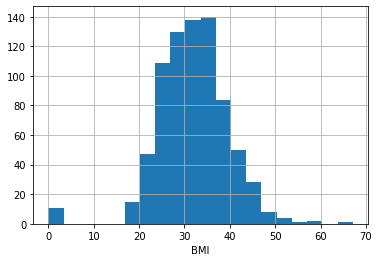

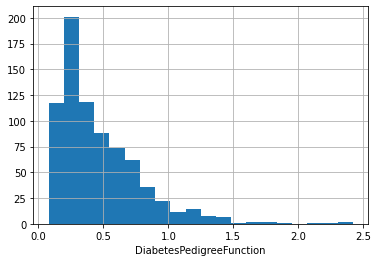

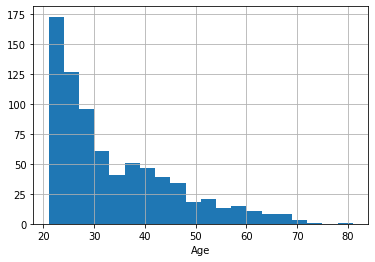

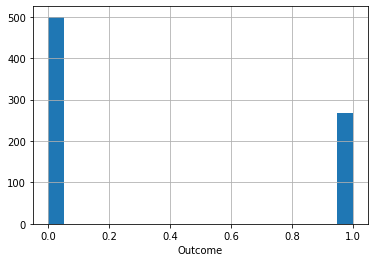

In [12]:
def plot_numerical_col(dataframe, numerical_col):           # we define a function to show numeric columns.
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)    # The reason we entered the block=true argument; We don't want the graphics that will show one after the other to overwhelm each other.

for col in df.columns:
    plot_numerical_col(df, col)

## Target vs Features

In [13]:
cols = [col for col in df.columns if "Outcome" not in col]

In [14]:
df.groupby("Outcome").agg({"Pregnancies": "mean"})

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




<a id="2"></a> <br>
# 2. Data Preprocessing

The missing values, null values and values equal to zero for the predictor variables need to be identified in the dataset. The predictor variables/features cannot have a zero value except for certain features, like for example the ‘Pregnancies’ feature in Dataset. These values need to be replaced with the mean values of the column. This is an important step to increase the accuracy of prediction, as faulty values increase the chances of incorrect predictions.

In [15]:
df.shape

(768, 9)

In [16]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [17]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [19]:
for col in cols:
    print(col, check_outlier(df, col))

replace_with_thresholds(df, "Insulin")

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [20]:
for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

In [21]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


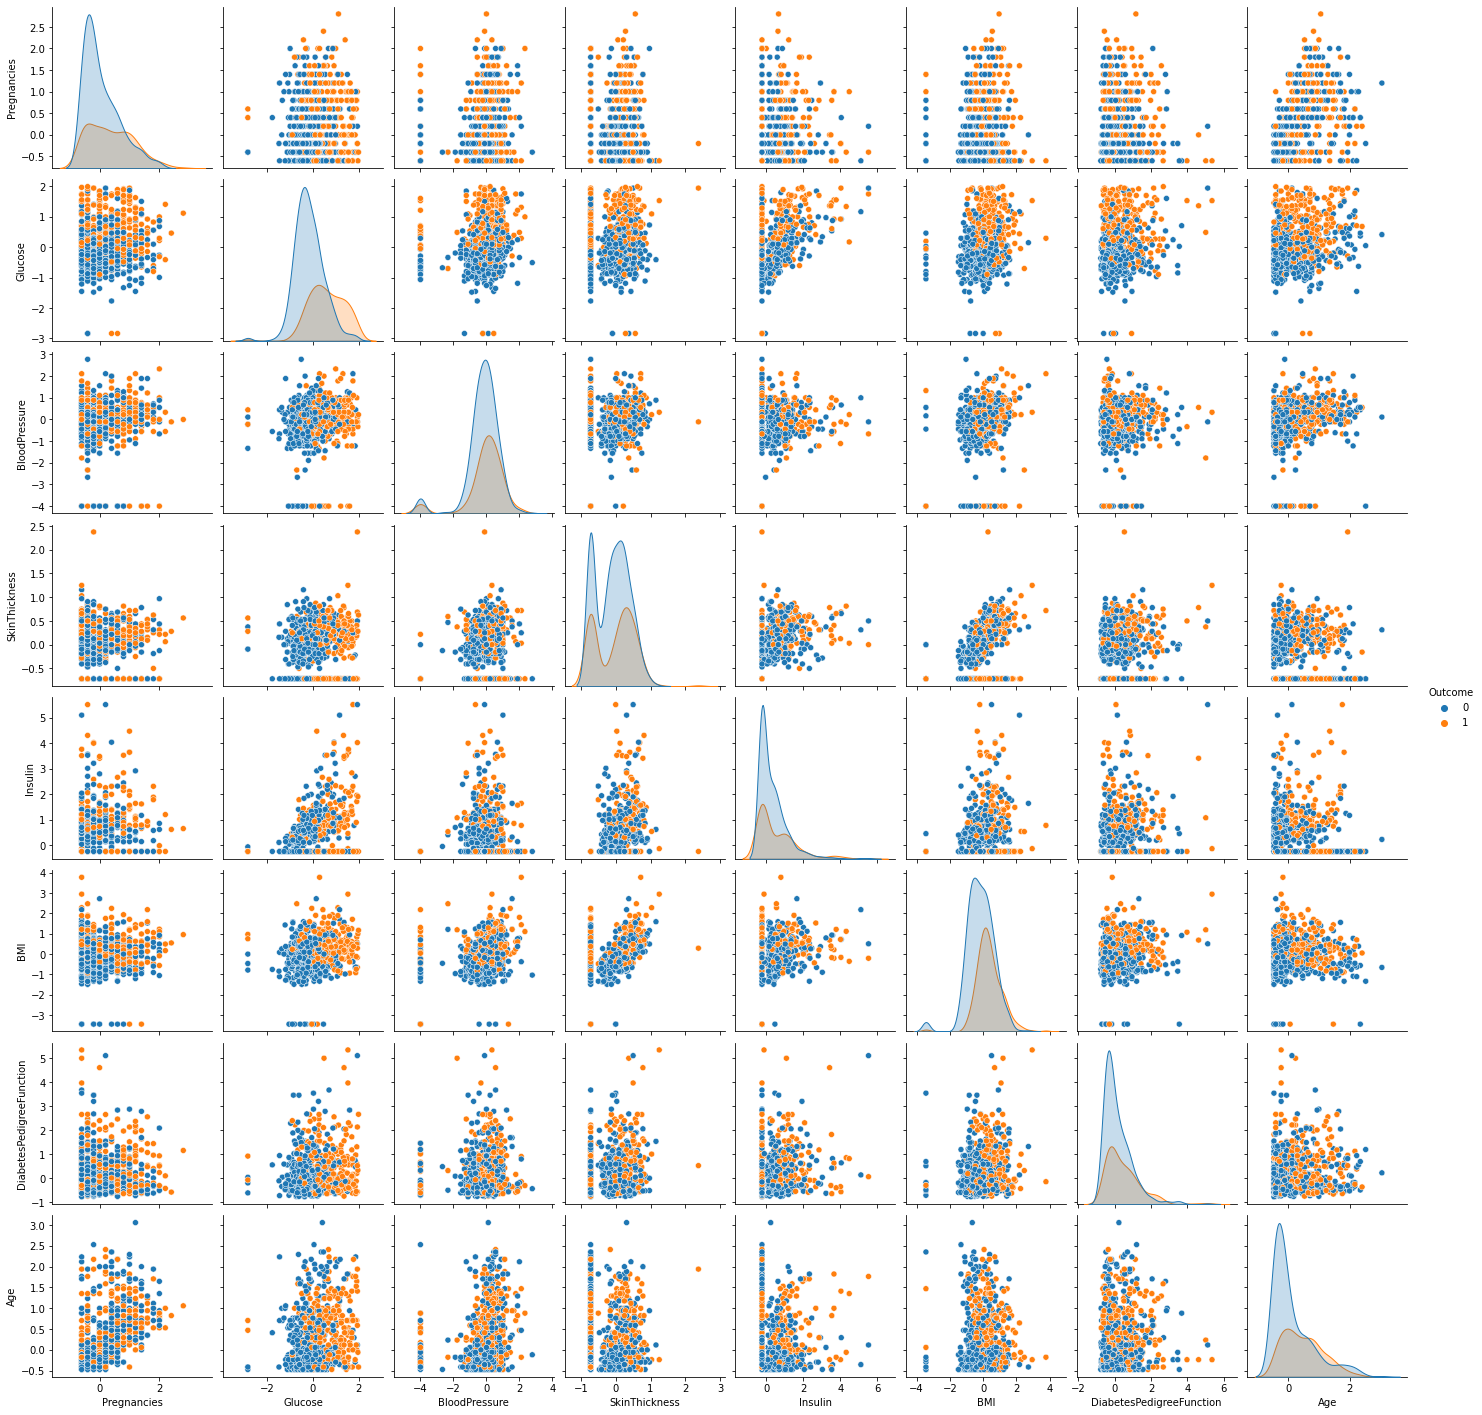

In [22]:
sns.pairplot(df, hue="Outcome")
plt.show()

<a id="3"></a> <br>
# 3. Model & Prediction

In [23]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [24]:
log_model = LogisticRegression().fit(X, y)

In [25]:
log_model.intercept_

array([-1.23439588])

In [26]:
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [27]:
y_pred = log_model.predict(X)

y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [28]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

<a id="4"></a> <br>
# 4.  Model Evaluation

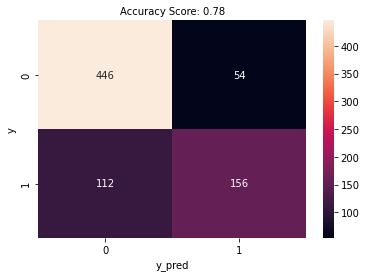

In [29]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

In [30]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



ROC AUC (Receiver Operating Characteristic Area Under the Curve) is a metric used to measure the performance of a classification model. ROC AUC compares the probability of the model's predictions being correct and incorrect and plots these probabilities according to a ROC (Receiver Operating Characteristic) curve. The ROC curve shows the relationship between the true positive (TP) rate (percentage of the model's correct predictions) and the false positive (FP) rate (percentage of the model's false predictions). The ROC AUC value is calculated based on the size of the area under the ROC curve and takes a value between 0 and 1. If a ROC AUC is 1, the model has made all of its predictions correctly. If a ROC AUC is 0, the model has made all of its predictions incorrectly. If a ROC AUC was 0.5, the accuracy of the model predictions had a random distribution. The ROC AUC value is a useful metric for measuring the performance of a classification model.

In [31]:
# ROC AUC
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8393955223880598

<a id="5"></a> <br>
# 5.  Model Validation: Holdout

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

log_model = LogisticRegression().fit(X_train, y_train)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



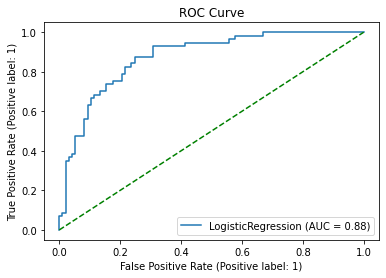

In [33]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'g--')
plt.show()

In [34]:
# AUC
roc_auc_score(y_test, y_prob)

0.8755652016639537

<a id="6"></a> <br>
# 6. Model Validation: 10-Fold Cross Validation

In [35]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [36]:
cv_results['test_accuracy']

array([0.77272727, 0.74675325, 0.75324675, 0.81699346, 0.77124183])

In [37]:
cv_results['test_accuracy'].mean() # Accuracy

0.7721925133689839

In [38]:
cv_results['test_precision'].mean() # Precision

0.7192472060223519

In [39]:
cv_results['test_recall'].mean() # Recall

0.5747030048916841

In [40]:
cv_results['test_f1'].mean()

0.6371421090986309

In [41]:
cv_results['test_roc_auc'].mean()

0.8327295597484277

<a id="7"></a> <br>
# 7. Prediction for A New Observation

After a model prediction has been made on a dataset, you can make a prediction for a new observation using a classification model of that model.

In [42]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [43]:
random_user = X.sample(1, random_state=45)
log_model.predict(random_user)

array([1])

***Load the values of a new observation into a Python data structure. For example, you can load it into a Pandas dataframe.***

In [44]:
new_obs = pd.DataFrame([[6, 148, 72, 35, 0, 33.6, 0.627, 50]], columns=cols)

In [45]:
log_model.predict(new_obs)    #Estimate a new observation

array([1])